# **Install And Upgrade Important Library**

In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.5 MB/s eta 0:00:00


# **Import Library To Be Used Later**

In [ ]:
import logging
import os
import random
import sys
from dataclasses import dataclass, field
from typing import Optional
import pandas as pd
import datasets
import evaluate
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
import torch

import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version, send_example_telemetry
from transformers.utils.versions import require_version


logger = logging.getLogger(__name__)

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
)

# **Dwonload Dataset From Personal Github Account**

In [ ]:
!wget "https://raw.githubusercontent.com/DeepProgram/random/main/blp23_sentiment_test_with_label.tsv"

--2023-09-10 11:09:10--  https://raw.githubusercontent.com/DeepProgram/random/main/blp23_sentiment_test_with_label.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1626269 (1.6M) [text/plain]
Saving to: ‘blp23_sentiment_test_with_label.tsv’

blp23_sentiment_tes 100%[===================>]   1.55M  --.-KB/s    in 0.02s   

2023-09-10 11:09:10 (69.3 MB/s) - ‘blp23_sentiment_test_with_label.tsv’ saved [1626269/1626269]



In [ ]:
!wget "https://raw.githubusercontent.com/DeepProgram/random/main/sentiment_analysis_data.zip"

--2023-09-10 11:09:10--  https://raw.githubusercontent.com/DeepProgram/random/main/sentiment_analysis_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2645403 (2.5M) [application/zip]
Saving to: ‘sentiment_analysis_data.zip’

sentiment_analysis_ 100%[===================>]   2.52M  --.-KB/s    in 0.02s   

2023-09-10 11:09:11 (106 MB/s) - ‘sentiment_analysis_data.zip’ saved [2645403/2645403]



# **Unzip Downloaded Data**

In [ ]:
!unzip -o /content/sentiment_analysis_data.zip

Archive:  /content/sentiment_analysis_data.zip
  inflating: blp23_sentiment_dev_test.tsv  
  inflating: blp23_sentiment_dev.tsv  
  inflating: blp23_sentiment_train.tsv  


# **Set File Path Of Dataset**

In [ ]:
train_file = '/content/blp23_sentiment_train.tsv'
validation_file = '/content/blp23_sentiment_dev.tsv'
test_file = '/content/blp23_sentiment_dev_test.tsv'

# **Initialize Training Arguments And Some Paramters**

In [ ]:
training_args = TrainingArguments(
    learning_rate=2e-5,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    output_dir="./bertBaseMultilingualNew/",
    overwrite_output_dir=True,
    remove_unused_columns=False,
    local_rank= 1,
    load_best_model_at_end=True,
    save_total_limit=2,
    save_strategy="no"
)

max_train_samples = None
max_eval_samples=None
max_predict_samples=None
max_seq_length = 512
batch_size = 16

# **Setup Logging Info**

In [ ]:
transformers.utils.logging.set_verbosity_info()

log_level = training_args.get_process_log_level()
logger.setLevel(log_level)
datasets.utils.logging.set_verbosity(log_level)
transformers.utils.logging.set_verbosity(log_level)
transformers.utils.logging.enable_default_handler()
transformers.utils.logging.enable_explicit_format()
logger.warning(
    f"Process rank: {training_args.local_rank}, device: {training_args.device}, n_gpu: {training_args.n_gpu}"
    + f" distributed training: {bool(training_args.local_rank != -1)}, 16-bits training: {training_args.fp16}"
)
logger.info(f"Training/evaluation parameters {training_args}")

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=False,
group_by_length=False,
half_precision_

# **Insert Model Name**

In [ ]:
model_name = 'bert-base-multilingual-cased'

In [ ]:
set_seed(training_args.seed)

# **Setup Functions And Variable To Process Text**

In [ ]:
punctuations = ["|","‘",">","<","*",   "।", ",", ";", ":", "?", "!", "'", ".", "\"", "-",
                "[", "]", "{", "}", "(", ")", '–', "—", "―", "~"]

def remove_url(word):
  return word.split("http")[0].strip()

def extreme_process(word):
  word_list = [word]
  splitter_list = ["**","*", "…", "-"]

  for i in splitter_list:
    if i in word:
      temp_list = word.split(i)
      word_list = list(filter(lambda x:x.strip() != "", temp_list))
      return word_list
  return word_list


def process_word(word):
  word = word.strip()
  if len(word) == 0:
    return []
  elif len(word) == 1:
    if word not in punctuations:
      return [word]
    else:
      return []
  else:
    word = remove_url(word)

    if len(word) == 0:
      return []
    elif len(word) == 1:
      if word in punctuations:
        return []
      else:
        return [word]
    else:
      if word[0] in punctuations:
        word = word[1:]
      if word[-1] in punctuations:
        word = word[:-1]

      word = extreme_process(word)

      return word


# **Insert Training Data In A Variable**

In [ ]:
l2id = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
train_df = pd.read_csv(train_file, sep='\t')
print(train_df.head())

               id                                               text     label
0           10856  এখানে আরো ভালো ভাবে দলীয় ও র এর অবস্থান পাকা হ...   Neutral
1   sentinob_1072                   চুয়াডাঙ্গা বাড়ি কে বলেছে আপনার   Neutral
2  sentinob_10530      ভাই সোনাই ঘোষ এর দই খেয়ে যাইতেন , খুব ই মজার   Positive
3            8001  সমার তালুকদার আপনার ছবিতে ফেসটা কেন জানি বন্য ...  Negative
4  sentinob_10144  ভাইয়া এই নুডলস টা কোথায় কিনতে পাওয়া যাবে প্লিজ...  Positive


# **Remove Unnecessary Character From Text And Update Text**

In [ ]:
for index, row in train_df.iterrows():
  unprocessed_spliited_word = row["text"].split(" ")
  processed_word_list = []
  for i in unprocessed_spliited_word:
    processed_word_list += process_word(i)
  train_df.at[index, "text"] = " ".join(processed_word_list)

In [ ]:
train_df['label'] = train_df['label'].map(l2id)
print(train_df.head())

               id                                               text  label
0           10856  এখানে আরো ভালো ভাবে দলীয় ও র এর অবস্থান পাকা হ...      1
1   sentinob_1072                   চুয়াডাঙ্গা বাড়ি কে বলেছে আপনার      1
2  sentinob_10530         ভাই সোনাই ঘোষ এর দই খেয়ে যাইতেন খুব ই মজার      2
3            8001  সমার তালুকদার আপনার ছবিতে ফেসটা কেন জানি বন্য ...      0
4  sentinob_10144  ভাইয়া এই নুডলস টা কোথায় কিনতে পাওয়া যাবে প্লিজ...      2


In [ ]:
!pip install wordcloud

In [ ]:
!wget "https://raw.githubusercontent.com/DeepProgram/random/main/kalpurush.ttf"

--2023-09-10 11:09:33--  https://raw.githubusercontent.com/DeepProgram/random/main/kalpurush.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 314592 (307K) [application/octet-stream]
Saving to: ‘kalpurush.ttf’

kalpurush.ttf       100%[===================>] 307.22K  --.-KB/s    in 0.01s   

2023-09-10 11:09:33 (24.7 MB/s) - ‘kalpurush.ttf’ saved [314592/314592]



In [ ]:
import numpy as np
import pandas as pd
import cv2
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

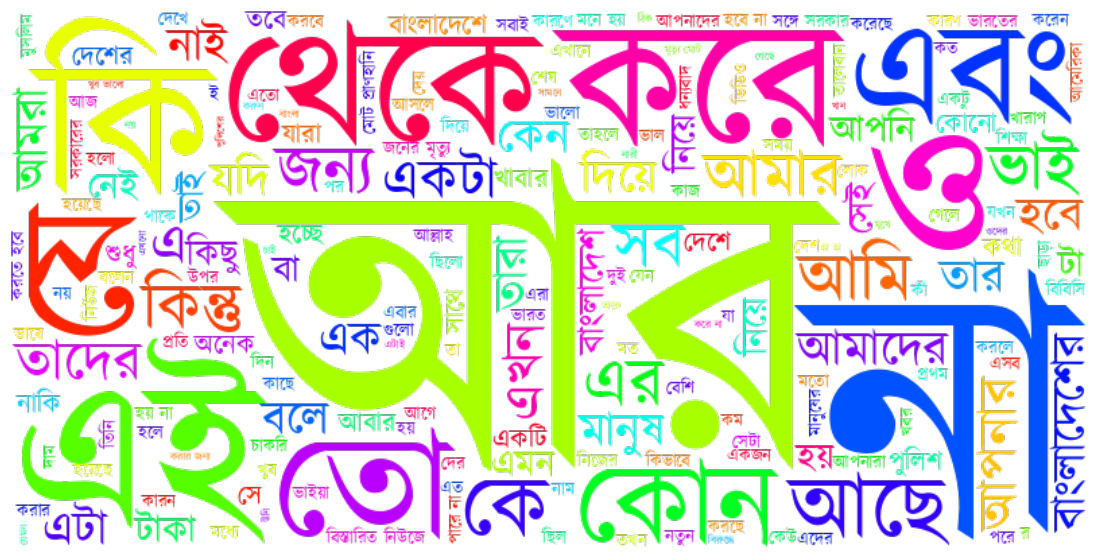

In [ ]:
refined_sentence = " ".join(train_df['text'])
regex = r"[\u0980-\u09FF]+"
wc = WordCloud(width=800, height=400,mode="RGBA",background_color=None,colormap="hsv",font_path="/content/kalpurush.ttf",regexp=regex).generate(refined_sentence)
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
train_df = Dataset.from_pandas(train_df)
print(train_df)

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 35266
})


# **Remove Unnecessary Character From Text And Update Data**

In [ ]:
validation_df = pd.read_csv(validation_file, sep='\t')
for index, row in validation_df.iterrows():
  unprocessed_spliited_word = row["text"].split(" ")
  processed_word_list = []
  for i in unprocessed_spliited_word:
    processed_word_list += process_word(i)
  validation_df.at[index, "text"] = " ".join(processed_word_list)


In [ ]:
validation_df['label'] = validation_df['label'].map(l2id)

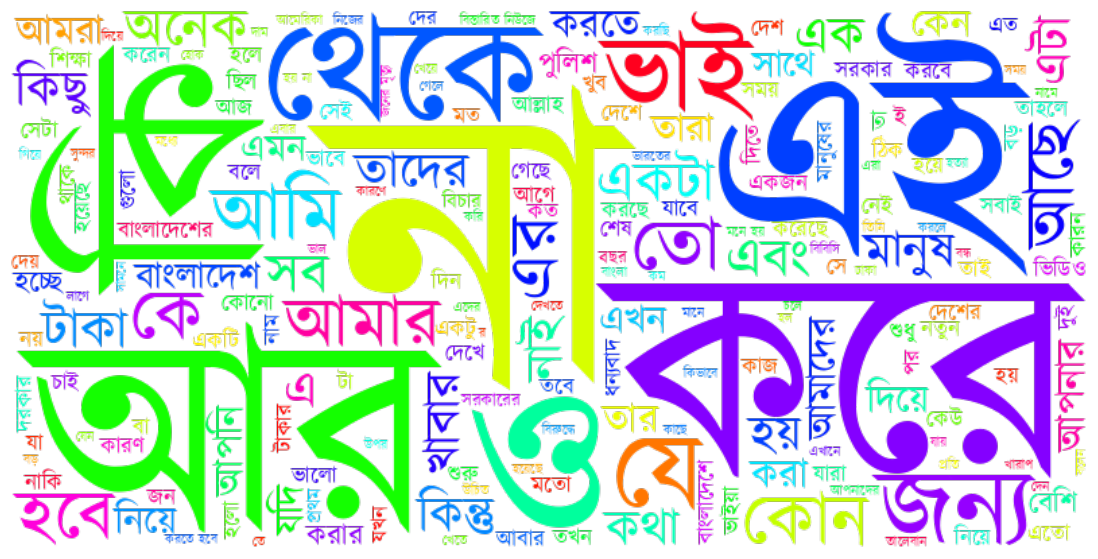

In [ ]:
refined_sentence = " ".join(validation_df['text'])
regex = r"[\u0980-\u09FF]+"
wc = WordCloud(width=800, height=400,mode="RGBA",background_color=None,colormap="hsv",font_path="/content/kalpurush.ttf",regexp=regex).generate(refined_sentence)
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
validation_df = Dataset.from_pandas(validation_df)
print(validation_df)

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 3934
})


In [ ]:
old_test_df = pd.read_csv(test_file, sep='\t')
print(old_test_df.head())
print(len(old_test_df))

      id                                               text
0  30670   * করোনায় আরো ১৮৭ জনের মৃত্যু; মোট প্রাণহানি ...
1   4125          চাপাবাজীর চাপে এবার ধামাচাপা পড়বে আসল ইসু
2  27077   কুয়েতে বাংলাদেশী ফল খেতে হামলে পড়ছেন প্রবাসীরা
3  17552  তিনি ছিলেন টেস্ট খেলা সবচেয়ে বেশি বয়সী জীবিত...
4   4137  চাল আর পাট গুলো উৎপাদন করতে যে কৃষকের বাঁশ ঢুক...
3426


In [ ]:
test_df = pd.read_csv("/content/blp23_sentiment_test_with_label.tsv", sep="\t")
print(test_df.head())
print(len(test_df))

      id                                               text     label
0   7135  মুখস্ত শিক্ষা দিয়ে কি করবে এই জাতি ? বাংলাদেশ...  Negative
1  28949  জর্ডানের সাবেক যুবরাজ প্রিন্স হামজার ভিডিও বার...  Negative
2  10210  আমার ছেলের দুর্ভাগ্য না সৌভাগ্য জানিনা জ্বর এর...   Neutral
3   9526  Pranoy Sen তখন পাকিস্তান ও আফগানিস্তান ভারতের ...   Neutral
4   2142                              আরো কত মিথ্যাচার করবে  Negative
6707


In [ ]:
test_df['label'] = test_df['label'].map(l2id)

# **Remove Unnecessary Character From Text And Update Data**

In [ ]:
for index, row in test_df.iterrows():
  unprocessed_spliited_word = row["text"].split(" ")
  processed_word_list = []
  for i in unprocessed_spliited_word:
    processed_word_list += process_word(i)
  test_df.at[index, "text"] = " ".join(processed_word_list)


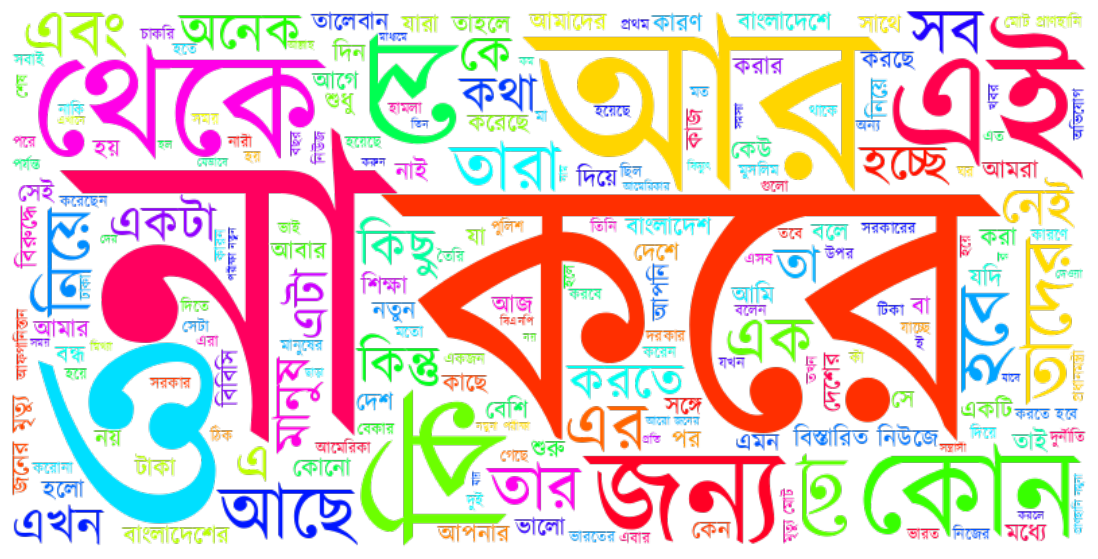

In [ ]:
refined_sentence = " ".join(test_df['text'])
regex = r"[\u0980-\u09FF]+"
wc = WordCloud(width=800, height=400,mode="RGBA",background_color=None,colormap="hsv",font_path="/content/kalpurush.ttf",regexp=regex).generate(refined_sentence)
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
test_df = Dataset.from_pandas(test_df)
print(test_df)

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 6707
})


# **Storing All The Dataset Files In A Dictionary**

In [ ]:
data_files = {"train": train_df, "validation": validation_df, "test": test_df}
for key in data_files.keys():
    logger.info(f"loading a local file for {key}")

INFO:__main__:loading a local file for train
INFO:__main__:loading a local file for validation
INFO:__main__:loading a local file for test


In [ ]:
raw_datasets = DatasetDict(
    {"train": train_df, "validation": validation_df, "test": test_df}
)

In [ ]:
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 35266
    })
    validation: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 3934
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 6707
    })
})


# **Storing Label List**

In [ ]:
label_list = raw_datasets["train"].unique("label")
print(label_list)

[1, 2, 0]


# **Sorting Label List**

In [ ]:
label_list.sort()  # sort the labels for determine
print(label_list)

[0, 1, 2]


# **Storing Total Number Of Label**

In [ ]:
num_labels = len(label_list)
print(num_labels)

3


# **Setting Up Config**

In [ ]:
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task=None,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
)

[INFO|configuration_utils.py:715] 2023-09-10 11:10:05,391 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/config.json
[INFO|configuration_utils.py:775] 2023-09-10 11:10:05,404 >> Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,

# **Seeting Up Tokenizer**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=None,
    use_fast=True,
    revision="main",
    use_auth_token=None,
)

[INFO|configuration_utils.py:715] 2023-09-10 11:10:06,299 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/config.json
[INFO|configuration_utils.py:775] 2023-09-10 11:10:06,312 >> Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_emb

[INFO|tokenization_utils_base.py:1852] 2023-09-10 11:10:08,201 >> loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/vocab.txt
[INFO|tokenization_utils_base.py:1852] 2023-09-10 11:10:08,203 >> loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/tokenizer.json
[INFO|tokenization_utils_base.py:1852] 2023-09-10 11:10:08,204 >> loading file added_tokens.json from cache at None
[INFO|tokenization_utils_base.py:1852] 2023-09-10 11:10:08,205 >> loading file special_tokens_map.json from cache at None
[INFO|tokenization_utils_base.py:1852] 2023-09-10 11:10:08,207 >> loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/tokenizer_config.json
[INFO|configuration_utils.py:715] 2023

# **Setting Up Model**

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    from_tf=bool(".ckpt" in model_name),
    config=config,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
    ignore_mismatched_sizes=False,
)

[INFO|modeling_utils.py:2857] 2023-09-10 11:10:21,605 >> loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/model.safetensors
[INFO|modeling_utils.py:3633] 2023-09-10 11:10:24,068 >> Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenc

In [ ]:
print(f"Model Name: {model_name}")
print(f"Number of Layers: {config.num_hidden_layers}")
print(f"Hidden Dimension: {config.hidden_size}")
print(f"Number of Attention Heads: {config.num_attention_heads}")
print(f"Intermediate Dimension: {config.intermediate_size}")
print(f"Total Parameters: {model.num_parameters()}")

Model Name: bert-base-multilingual-cased
Number of Layers: 12
Hidden Dimension: 768
Number of Attention Heads: 12
Intermediate Dimension: 3072
Total Parameters: 177855747


# **Separeting Other Column Than Label**

In [ ]:
non_label_column_names = [name for name in raw_datasets["train"].column_names if name != "label"]
print(non_label_column_names)

['id', 'text']


# **Storing The Key Value Of Text Column**

In [ ]:
sentence_key= non_label_column_names[1]
print(sentence_key)

text


In [ ]:
padding = "max_length"
label_to_id = None

if (model.config.label2id != PretrainedConfig(num_labels=num_labels).label2id):
    # Some have all caps in their config, some don't.
    label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
    if sorted(label_name_to_id.keys()) == sorted(label_list):
        label_to_id = {i: int(label_name_to_id[label_list[i]]) for i in range(num_labels)}
    else:
        logger.warning(
            "Your model seems to have been trained with labels, but they don't match the dataset: ",
            f"model labels: {sorted(label_name_to_id.keys())}, dataset labels: {sorted(label_list)}."
            "\nIgnoring the model labels as a result.",)

In [ ]:
if label_to_id is not None:
    model.config.label2id = label_to_id
    model.config.id2label = {id: label for label, id in config.label2id.items()}

In [ ]:
if 128 > tokenizer.model_max_length:
    logger.warning(
        f"The max_seq_length passed ({128}) is larger than the maximum length for the"
        f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}.")

In [ ]:
max_seq_length = min(128, tokenizer.model_max_length)
print(max_seq_length)

128


In [ ]:
def preprocess_function(examples):
    # Tokenize the texts
    args = (
        (examples[sentence_key],))
    result = tokenizer(*args, padding=padding, max_length=max_seq_length, truncation=True)

    # Map labels to IDs (not necessary for GLUE tasks)
    if label_to_id is not None and "label" in examples:
        result["label"] = [(label_to_id[l] if l != -1 else -1) for l in examples["label"]]
    return result

In [ ]:
raw_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    load_from_cache_file=True,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/35266 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/3934 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/6707 [00:00<?, ? examples/s]

In [ ]:
if "train" not in raw_datasets:
    raise ValueError("requires a train dataset")

In [ ]:
train_dataset = raw_datasets["train"]
print(train_dataset)

Dataset({
    features: ['id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 35266
})


In [ ]:
if "validation" not in raw_datasets:
    raise ValueError("requires a validation dataset")

In [ ]:
eval_dataset = raw_datasets["validation"]
print(eval_dataset)

Dataset({
    features: ['id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3934
})


In [ ]:
print(max_eval_samples)

None


In [ ]:
if max_eval_samples is not None:
    max_eval_samples_n = min(len(eval_dataset), max_eval_samples)
    eval_dataset = eval_dataset.select(range(max_eval_samples_n))

In [ ]:
if "test" not in raw_datasets and "test_matched" not in raw_datasets:
    raise ValueError("requires a test dataset")

In [ ]:
predict_dataset = raw_datasets["test"]
print(predict_dataset)

Dataset({
    features: ['id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6707
})


In [ ]:
print(max_predict_samples)

None


In [ ]:
if max_predict_samples is not None:
    max_predict_samples_n = min(len(predict_dataset), max_predict_samples)
    predict_dataset = predict_dataset.select(range(max_predict_samples_n))

In [ ]:
for index in random.sample(range(len(train_dataset)), 3):
    logger.info(f"Sample {index} of the training set: {train_dataset[index]}.")

INFO:__main__:Sample 7296 of the training set: {'id': '2612', 'text': 'এই বিচারকের মেয়ে অথবা বোনকে ধর্ষণ করে ৫০ হাজার টাকা জরিমানা দেয়া হবে এবং সেইটা ধর্ষণের সাথে সাথেই পেইড করা হবে যদি রাজি থাকে তাহলে আমিও রাজি', 'label': 0, 'input_ids': [101, 14112, 970, 12235, 85746, 44020, 100, 93102, 970, 82825, 18243, 966, 11128, 111240, 34070, 20513, 13334, 48782, 979, 100277, 15010, 958, 81661, 955, 82742, 29454, 12079, 100, 53761, 12051, 61899, 36715, 966, 11128, 111240, 34070, 75718, 22904, 22904, 14998, 968, 59712, 38044, 14704, 53761, 973, 64010, 974, 100277, 12235, 30437, 52038, 26145, 28799, 938, 37376, 18262, 974, 100277, 12235, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
metric = evaluate.load("accuracy")

# **Creating Function To Calculate Micro F1 Score**

In [ ]:
def calculate_micro_f1_score(true_positives, false_positives, false_negatives):
    total_tp = sum(true_positives)
    total_fp = sum(false_positives)
    total_fn = sum(false_negatives)

    micro_precision = total_tp / (total_tp + total_fp + 1e-9)
    micro_recall = total_tp / (total_tp + total_fn + 1e-9)

    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall + 1e-9)

    return micro_f1

# **Creating Function To Show Output Of Accuracy And Micro F1 Score**

In [ ]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)

    labels = p.label_ids
    # Initialize dictionaries to store TP, FP, and FN for each class
    true_positives = {label: 0 for label in range(num_labels)}
    false_positives = {label: 0 for label in range(num_labels)}
    false_negatives = {label: 0 for label in range(num_labels)}

    for label, pred in zip(labels, preds):
        for class_id in range(num_labels):
            if class_id == label and class_id == pred:
                true_positives[class_id] += 1
            elif class_id != label and class_id == pred:
                false_positives[class_id] += 1
            elif class_id == label and class_id != pred:
                false_negatives[class_id] += 1

    return {
        "micro_f1_score": calculate_micro_f1_score(
            list(true_positives.values()), list(false_positives.values()), list(false_negatives.values())
        ),
        "accuracy": (preds == p.label_ids).astype(np.float32).mean().item()
    }


In [ ]:
data_collator = default_data_collator

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="steps",  # Changed to "steps"
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=3,  # Limit the number of saved checkpoints
    load_best_model_at_end=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Perform cross-validation
results = trainer.evaluate()
print(results)

[INFO|training_args.py:1276] 2023-09-10 11:10:38,419 >> using `logging_steps` to initialize `eval_steps` to 500
[INFO|training_args.py:1332] 2023-09-10 11:10:38,422 >> Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
[INFO|training_args.py:1764] 2023-09-10 11:10:38,425 >> PyTorch: setting up devices
[INFO|training_args.py:1485] 2023-09-10 11:10:38,429 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
[INFO|trainer.py:752] 2023-09-10 11:10:43,749 >> The following columns in the evaluation set don't have a corresponding argument in `BertFo

{'eval_loss': 1.0689014196395874, 'eval_micro_f1_score': 0.4389933904505747, 'eval_accuracy': 0.4389933943748474, 'eval_runtime': 48.2153, 'eval_samples_per_second': 81.592, 'eval_steps_per_second': 10.204}


In [ ]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     compute_metrics=compute_metrics,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
# )

In [ ]:
train_result = trainer.train()

[INFO|trainer.py:752] 2023-09-10 11:11:33,218 >> The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:1712] 2023-09-10 11:11:33,247 >> ***** Running training *****
[INFO|trainer.py:1713] 2023-09-10 11:11:33,249 >>   Num examples = 35,266
[INFO|trainer.py:1714] 2023-09-10 11:11:33,254 >>   Num Epochs = 3
[INFO|trainer.py:1715] 2023-09-10 11:11:33,256 >>   Instantaneous batch size per device = 8
[INFO|trainer.py:1718] 2023-09-10 11:11:33,259 >>   Total train batch size (w. parallel, distributed & accumulation) = 8
[INFO|trainer.py:1719] 2023-09-10 11:11:33,260 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1720] 2023-09-10 11:11:33,262 >>   Total optimization steps = 13,227
[INFO|trainer.py:1721] 2023-09-10 11:11:33,266 >>   Number of trainable parameters =

Step,Training Loss,Validation Loss,Micro F1 Score,Accuracy
500,1.043300,0.980740,0.528724,0.528724
1000,0.950000,0.903383,0.596340,0.596340
1500,0.911200,0.898878,0.583884,0.583884
2000,0.910900,0.872233,0.601678,0.601678
2500,0.891400,0.865024,0.604474,0.604474
3000,0.890500,0.867123,0.607016,0.607016
3500,0.861500,0.859989,0.624301,0.624301
4000,0.855400,0.878971,0.615404,0.615404
4500,0.842100,0.878531,0.621251,0.621251
5000,0.768800,0.866370,0.624555,0.624555


[INFO|trainer.py:752] 2023-09-10 11:14:30,913 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3115] 2023-09-10 11:14:30,917 >> ***** Running Evaluation *****
[INFO|trainer.py:3117] 2023-09-10 11:14:30,918 >>   Num examples = 3934
[INFO|trainer.py:3120] 2023-09-10 11:14:30,921 >>   Batch size = 8


[INFO|trainer.py:2841] 2023-09-10 11:15:29,268 >> Saving model checkpoint to ./output/checkpoint-500
[INFO|configuration_utils.py:460] 2023-09-10 11:15:29,271 >> Configuration saved in ./output/checkpoint-500/config.json
[INFO|modeling_utils.py:1992] 2023-09-10 11:15:36,493 >> Model weights saved in ./output/checkpoint-500/pytorch_model.bin
[INFO|tokenization_utils_base.py:2235] 2023-09-10 11:15:37,193 >> tokenizer config file saved in ./output/checkpoint-500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2242] 2023-09-10 11:15:37,197 >> Special tokens file saved in ./output/checkpoint-500/special_tokens_map.json
[INFO|trainer.py:752] 2023-09-10 11:18:47,673 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3115] 2023-09-10 11:18:47,678 >> ***** 

In [ ]:
metrics = train_result.metrics
max_train_samples = (
    max_train_samples if max_train_samples is not None else len(train_dataset)
)
metrics["train_samples"] = min(max_train_samples, len(train_dataset))

In [ ]:
trainer.save_model()
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

[INFO|trainer.py:2841] 2023-09-10 13:04:31,163 >> Saving model checkpoint to ./output
[INFO|configuration_utils.py:460] 2023-09-10 13:04:31,167 >> Configuration saved in ./output/config.json
[INFO|modeling_utils.py:1992] 2023-09-10 13:04:34,051 >> Model weights saved in ./output/pytorch_model.bin
[INFO|tokenization_utils_base.py:2235] 2023-09-10 13:04:35,931 >> tokenizer config file saved in ./output/tokenizer_config.json
[INFO|tokenization_utils_base.py:2242] 2023-09-10 13:04:35,936 >> Special tokens file saved in ./output/special_tokens_map.json


***** train metrics *****
  epoch                    =        3.0
  total_flos               =  6481277GF
  train_loss               =     0.7633
  train_runtime            = 1:52:57.17
  train_samples            =      35266
  train_samples_per_second =     15.611
  train_steps_per_second   =      1.952


In [ ]:
logger.info("*** Evaluate ***")

metrics = trainer.evaluate(eval_dataset=eval_dataset)

max_eval_samples = (
    max_eval_samples if max_eval_samples is not None else len(eval_dataset)
)
metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

INFO:__main__:*** Evaluate ***
[INFO|trainer.py:752] 2023-09-10 13:04:36,199 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3115] 2023-09-10 13:04:36,206 >> ***** Running Evaluation *****
[INFO|trainer.py:3117] 2023-09-10 13:04:36,208 >>   Num examples = 3934
[INFO|trainer.py:3120] 2023-09-10 13:04:36,210 >>   Batch size = 8


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.6579
  eval_loss               =     0.8193
  eval_micro_f1_score     =     0.6579
  eval_runtime            = 0:00:56.77
  eval_samples            =       3934
  eval_samples_per_second =     69.295
  eval_steps_per_second   =      8.666


In [ ]:
from sklearn.metrics import accuracy_score
predictions = trainer.predict(predict_dataset).predictions
predicted_labels = predictions.argmax(axis=1)
actual_labels = predict_dataset['label']
accuracy = accuracy_score(actual_labels, predicted_labels)
print("Test Accuracy:", accuracy)

[INFO|trainer.py:752] 2023-09-10 13:05:33,004 >> The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3115] 2023-09-10 13:05:33,011 >> ***** Running Prediction *****
[INFO|trainer.py:3117] 2023-09-10 13:05:33,016 >>   Num examples = 6707
[INFO|trainer.py:3120] 2023-09-10 13:05:33,020 >>   Batch size = 8


Test Accuracy: 0.6444013717012077


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score


true_labels = predict_dataset["label"]


classification_rep = classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1", "Class 2"])
print("Classification Report:\n", classification_rep)

macro_f1 = f1_score(true_labels, predicted_labels, average="macro")
micro_f1 = f1_score(true_labels, predicted_labels, average="micro")
print(f"Macro F1 Score: {macro_f1}")
print(f"Micro F1 Score: {micro_f1}")

precision = precision_score(true_labels, predicted_labels, average="weighted")  # For binary classification
recall = recall_score(true_labels, predicted_labels, average="weighted")  # For binary classification
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.68      0.77      0.72      3338
     Class 1       0.46      0.29      0.36      1277
     Class 2       0.65      0.66      0.66      2092

    accuracy                           0.64      6707
   macro avg       0.60      0.57      0.58      6707
weighted avg       0.63      0.64      0.63      6707

Macro F1 Score: 0.5792230620681947
Micro F1 Score: 0.6444013717012077
Precision: 0.629545635096436
Recall: 0.6444013717012077


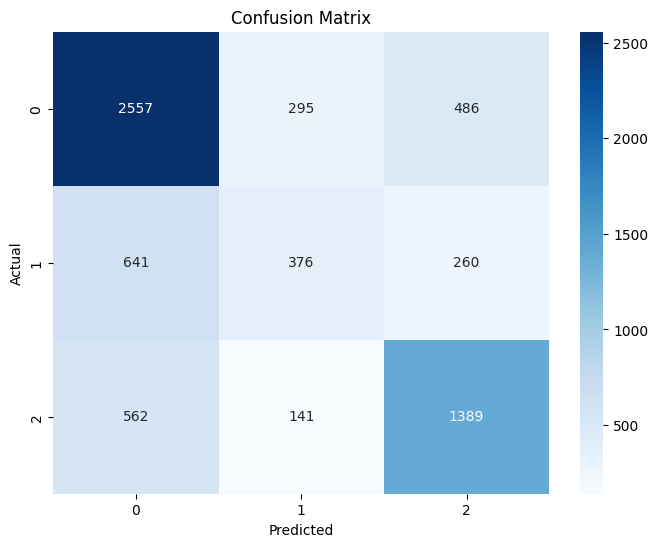

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(actual_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# id2l = {0:'Negative', 1:'Neutral', 2:'Positive'}
# logger.info("*** Predict ***")

# ids = predict_dataset['id']
# predict_dataset = predict_dataset.remove_columns("id")
# predictions = trainer.predict(predict_dataset, metric_key_prefix="predict").predictions
# predictions = np.argmax(predictions, axis=1)
# output_predict_file = os.path.join(training_args.output_dir, f"predict_results.tsv")
# if trainer.is_world_process_zero():
#     with open(output_predict_file, "w") as writer:
#         logger.info(f"***** Predict results *****")
#         writer.write("id\tlabel\n")
#         for index, item in enumerate(predictions):
#             item = label_list[item]
#             item = id2l[item]
#             writer.write(f"{ids[index]}\t{item}\n")

In [ ]:
import pandas as pd

In [ ]:
l2id = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
train_df = pd.read_csv(train_file, sep='\t')
train_df['label'] = train_df['label'].map(l2id)
print(train_df.head())

               id                                               text  label
0           10856  এখানে আরো ভালো ভাবে দলীয় ও র এর অবস্থান পাকা হ...      1
1   sentinob_1072                   চুয়াডাঙ্গা বাড়ি কে বলেছে আপনার      1
2  sentinob_10530      ভাই সোনাই ঘোষ এর দই খেয়ে যাইতেন , খুব ই মজার       2
3            8001  সমার তালুকদার আপনার ছবিতে ফেসটা কেন জানি বন্য ...      0
4  sentinob_10144  ভাইয়া এই নুডলস টা কোথায় কিনতে পাওয়া যাবে প্লিজ...      2


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
words = []
uniqueWords = set()
for sent in train_df["text"]:
  unprocessed_spliited_word = sent.split(" ")
  processed_word_list = []
  for i in unprocessed_spliited_word:
    processed_word_list += process_word(i)
  if processed_word_list:
        words.append(processed_word_list)
  uniqueWords = uniqueWords.union(set(processed_word_list))

In [ ]:
print(words[:10])

[['এখানে', 'আরো', 'ভালো', 'ভাবে', 'দলীয়', 'ও', 'র', 'এর', 'অবস্থান', 'পাকা', 'হলো', 'কি'], ['চুয়াডাঙ্গা', 'বাড়ি', 'কে', 'বলেছে', 'আপনার'], ['ভাই', 'সোনাই', 'ঘোষ', 'এর', 'দই', 'খেয়ে', 'যাইতেন', 'খুব', 'ই', 'মজার'], ['সমার', 'তালুকদার', 'আপনার', 'ছবিতে', 'ফেসটা', 'কেন', 'জানি', 'বন্য', 'বন্য', 'লাগতেসে', 'বুঝলাম', 'না'], ['ভাইয়া', 'এই', 'নুডলস', 'টা', 'কোথায়', 'কিনতে', 'পাওয়া', 'যাবে', 'প্লিজ', 'একটু', 'বলবেন'], ['বাংলাদেশে', 'ফেসবুক', 'ডট', 'কম', 'ডট', 'বিডি', 'ডোমেইন', 'ব্যবহারে', 'নিষেধাজ্ঞা'], ['শাউয়ার', 'মাগি', 'তরে', 'এত', 'রিপোর্ট', 'মারি', 'তাও', 'আসে', 'কেন', 'ভিডিও'], ['একপিছ', 'খাসির', 'হাড্ডি', '220', 'তুই', 'খা'], ['এই', 'জিনিস', 'সবজি', 'দিয়ে', 'খেলে', 'জমার', 'কথা', 'না', 'কিন্তু', 'ভর্তা', 'দিয়ে', 'টেস্ট', 'করে', 'দেখবেন', 'মাথা', 'নষ্ট'], ['Mohi@', 'ভারত', 'যদি', 'বাংলাদেশের', 'ওপর', 'করে', 'তখন']]


In [ ]:
import math
newWords = []
for i in words:
    myDict = dict.fromkeys(uniqueWords,0)
    for word in i:
        myDict[word] += 1
    newWords.append(myDict)

def computeTF(wordDict,bagOfWords):
    tfDict = {}
    bagOfWordsCount =  len(bagOfWords)
    for word,count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

tfList = []
for i in range(len(newWords)):
    tf = computeTF(newWords[i],words[i])
    tfList.append(tf)


def computeIDF(docs):
    N = len(docs)
    idfDict = dict.fromkeys(docs[0].keys(),0)

    for doc in docs:
        for word,val in doc.items():
            if val > 0: idfDict[word] += 1
    for word,val in idfDict.items():
        idfDict[word] = math.log(N / float(val))

    return idfDict

idfs = computeIDF(newWords)


def computeTFIDF(tfList,idfs):
    tfIDFList = []
    for tfItem in tfList:
        tfidfs = {}
        for word,tf in tfItem.items():
            tfidfs[word] = tf  * idfs[word]
        tfIDFList.append(tfidfs)
    return tfIDFList

tfIdfList = computeTFIDF(tfList,idfs)
newdf = pd.DataFrame(tfIdfList)

In [ ]:
newdf